Import & Settings

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import tensorflow as tf
from itertools import product
from keras.models import Model
from keras.layers import Input, Dense
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

Load and process data

In [7]:
from google.colab import files
uploaded = files.upload()

Saving market_data.xlsx to market_data (1).xlsx


In [8]:
df = pd.read_excel("market_data.xlsx")
# Show first rows
print(df.columns.tolist())
# Delete columns Date and target _MKT
X_full = df.drop(columns=["Date", "_MKT"])
# Remove extra spaces
df.columns = df.columns.str.strip()

['Date', 'EMP', 'PE', 'CAPE', 'DY', 'Rho', 'MOV ', 'IR', 'RR', 'Y02', 'Y10', 'STP', 'CF', 'MG', 'RV', 'ED', 'UN', 'GDP', 'M2', 'CPI', 'DIL', 'YSS', 'NYF', '_AU', '_DXY', '_LCP', '_TY', '_OIL', '_MKT', '_VA', '_GR']


Define signal sets

In [9]:
signal_sets = {
    "Set 1: Valuation"        : ['PE', 'CAPE', 'DY'],
    "Set 2: Interest Rates"   : ['IR', 'RR', 'Y02', 'Y10', 'STP'],
    "Set 3: Macro Conditions" : ['GDP', 'M2', 'CPI', 'UN', 'CF'],
    "Set 4: Corporate Health" : ['MG', 'RV', 'ED'],
    "Set 5: Risk Sentiment"   : ['Rho', 'MOV', 'YSS', 'NYF', '_DXY', '_OIL'],
    "Set 6: Style & Asset"    : ['_VA', '_GR', '_AU', '_TY'],
    "Set 7: Full Set"         : [col for col in df.columns if col not in ['Date', '_MKT']]
}


Apply standard AE

In [10]:
autoencoder_results = {}

for set_name, columns in signal_sets.items():

    # Prepare data
    data = df[columns].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    # AE architecture
    input_dim = X_scaled.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(4, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Training
    history = autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=16, verbose=0)

    # Save results
    loss = history.history['loss']
    autoencoder_results[set_name] = {
        "loss": loss,
        "final_loss": loss[-1]
    }


In [11]:
def train_ae_and_get_latent_codes(X_train, X_test, epochs=100, latent_dim=4):

    # Scaling (zero mean, unit variance)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # AE architecture
    input_dim = X_train.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(latent_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Training
    autoencoder.fit(X_train_scaled, X_train_scaled, epochs=epochs, batch_size=16, verbose=0)

    # Latent encoder model
    encoder = Model(inputs=input_layer, outputs=encoded)
    Z_train = encoder.predict(X_train_scaled)
    Z_test = encoder.predict(X_test_scaled)

    return Z_train, Z_test


Information Coefficient

In [12]:
ic_results_ae = {}
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

for set_name, columns in signal_sets.items():
    data = df[columns + ['_MKT']].dropna()
    X = data[columns].values
    y = data['_MKT'].shift(-1).dropna().values # Target
    X = X[:-1]  # allign

    ic_folds = []

    # Perform time series cross-validation
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train on training data and get latent representations
        Z_train, Z_test = train_ae_and_get_latent_codes(X_train, X_test)

        # Fit a linear regression model on the latent features
        model = LinearRegression()
        model.fit(Z_train, y_train)
        y_pred = model.predict(Z_test) # Predict market returns

        if np.std(y_pred) > 0 and np.std(y_test) > 0:
            ic = spearmanr(y_pred, y_test).correlation
            ic_folds.append(ic)
        else:
            ic_folds.append(np.nan)

    ic_results_ae[set_name] = np.nanmean(ic_folds)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11

Sharpe Ratio

In [13]:
sharpe_results_ae = {}
tscv = TimeSeriesSplit(n_splits=5)

for set_name, columns in signal_sets.items():
    data = df[columns + ['_MKT']].dropna()
    X = data[columns].values
    y = data['_MKT'].shift(-1).dropna().values
    X = X[:-1]

    pnl_all = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        Z_train, Z_test = train_ae_and_get_latent_codes(X_train, X_test)

        model = LinearRegression()
        model.fit(Z_train, y_train)
        y_pred = model.predict(Z_test)

        pnl = y_pred * y_test
        pnl_all.extend(pnl)


    pnl_all = np.array(pnl_all)
    sharpe = np.mean(pnl_all) / np.std(pnl_all) * np.sqrt(252)
    sharpe_results_ae[set_name] = sharpe



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/1

Results

In [14]:
# Reconstruct results
results = []

for set_name in ic_results_ae:
    avg_ic = ic_results_ae[set_name]
    sharpe = sharpe_results_ae[set_name]

    results.append({
        "Signal Set": set_name,
        "Avg IC": round(avg_ic, 4),
        "Avg Sharpe": round(sharpe, 4)
    })

results_df_ae = pd.DataFrame(results).sort_values(
    ["Avg IC", "Avg Sharpe"], ascending=False
)

print(results_df_ae)


                Signal Set  Avg IC  Avg Sharpe
5     Set 6: Style & Asset  0.9235      7.0884
6          Set 7: Full Set  0.4259     11.5637
0         Set 1: Valuation  0.2630     12.5045
1    Set 2: Interest Rates  0.2401     12.7565
3  Set 4: Corporate Health  0.1811     10.7031
4    Set 5: Risk Sentiment -0.1897     14.5394
2  Set 3: Macro Conditions -0.5965     13.3593


Apply Contractive Autoencoder

In [15]:
class ContractiveBottleneck(Layer):
    def __init__(self, units, lam=1e-4, **kwargs):
        super(ContractiveBottleneck, self).__init__(**kwargs)
        self.units = units
        self.lam = lam
        self.dense = Dense(units, activation='sigmoid', name='bottleneck')

    def call(self, inputs):
        h = self.dense(inputs)
        dh = h * (1 - h)  # derivative of sigmoid
        contractive_loss = self.lam * tf.reduce_sum(tf.square(self.dense.kernel)) * tf.reduce_sum(tf.square(dh))
        self.add_loss(contractive_loss)
        return h


In [16]:
def train_cae_and_get_latent_codes(X_train, X_test, lam=1e-4, latent_dim=3, epochs=100):

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # CAE architecture
    input_dim = X_train.shape[1]
    input_layer = Input(shape=(input_dim,))
    x = Dense(12, activation='relu')(input_layer)
    x = Dense(6, activation='relu')(x)
    bottleneck = ContractiveBottleneck(latent_dim, lam=lam)(x)
    x = Dense(6, activation='relu')(bottleneck)
    x = Dense(12, activation='relu')(x)
    output_layer = Dense(input_dim, activation='linear')(x)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(X_train_scaled, X_train_scaled, epochs=epochs, batch_size=16, verbose=0)

    encoder = Model(inputs=input_layer, outputs=bottleneck)
    Z_train = encoder.predict(X_train_scaled)
    Z_test = encoder.predict(X_test_scaled)

    return Z_train, Z_test


Information Coefficient

In [17]:
ic_results_cae = {}
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

for set_name, columns in signal_sets.items():
    data = df[columns + ['_MKT']].dropna()
    X = data[columns].values
    y = data['_MKT'].shift(-1).dropna().values
    X = X[:-1]

    ic_folds = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        Z_train, Z_test = train_cae_and_get_latent_codes(X_train, X_test)

        model = LinearRegression()
        model.fit(Z_train, y_train)
        y_pred = model.predict(Z_test)

        if np.std(y_pred) > 0 and np.std(y_test) > 0:
            ic = spearmanr(y_pred, y_test).correlation
            ic_folds.append(ic)
        else:
            ic_folds.append(np.nan)

    ic_results_cae[set_name] = np.nanmean(ic_folds)



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━

Sharpe Ratio

In [18]:
sharpe_results_cae = {}
tscv = TimeSeriesSplit(n_splits=5)

for set_name, columns in signal_sets.items():
    data = df[columns + ['_MKT']].dropna()
    X = data[columns].values
    y = data['_MKT'].shift(-1).dropna().values
    X = X[:-1]

    pnl_all = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        Z_train, Z_test = train_cae_and_get_latent_codes(X_train, X_test)

        model = LinearRegression()
        model.fit(Z_train, y_train)
        y_pred = model.predict(Z_test)

        pnl = y_pred * y_test
        pnl_all.extend(pnl)

    pnl_all = np.array(pnl_all)
    sharpe = np.mean(pnl_all) / np.std(pnl_all) * np.sqrt(252)
    sharpe_results_cae[set_name] = sharpe


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━

Result Contractive Autoencoder

In [19]:
# Reconstruct results CAE
results_cae = []

for set_name in ic_results_cae:
    avg_ic = np.mean(ic_results_cae[set_name])
    sharpe = sharpe_results_cae[set_name]
    results_cae.append({
        "Signal Set": set_name,
        "Avg IC": round(avg_ic, 4),
        "Avg Sharpe": round(sharpe, 4)
    })

results_df_cae = pd.DataFrame(results_cae).sort_values(
    ["Avg IC", "Avg Sharpe"], ascending=False
)

print(results_df_cae)

                Signal Set  Avg IC  Avg Sharpe
3  Set 4: Corporate Health  0.3214     12.6354
1    Set 2: Interest Rates  0.1780     12.9955
6          Set 7: Full Set  0.1126     11.6900
0         Set 1: Valuation  0.0423     10.9037
5     Set 6: Style & Asset -0.1357     10.8949
2  Set 3: Macro Conditions -0.3939     12.2814
4    Set 5: Risk Sentiment -0.4369     10.9919


Apply Variational Autoencoder

In [20]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(Model):
    def __init__(self, original_dim, latent_dim=3):
        super(VAE, self).__init__()
        self.original_dim = original_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(original_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(latent_dim + latent_dim),  # z_mean + z_log_var
        ])

        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(original_dim),
        ])
        self.sampler = Sampling()

    def call(self, inputs):
        z_params = self.encoder(inputs)
        z_mean, z_log_var = tf.split(z_params, num_or_size_splits=2, axis=1)
        z = self.sampler((z_mean, z_log_var))
        reconstruction = self.decoder(z)

        # KL divergence
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        self.add_loss(tf.reduce_mean(kl_loss))
        return reconstruction

In [21]:
def train_vae_and_get_latent_codes(X_train, X_test, original_dim, latent_dim=3, epochs=100):
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    vae = VAE(original_dim=original_dim, latent_dim=latent_dim)
    vae.compile(optimizer='adam', loss='mse')
    vae.fit(X_train_scaled, X_train_scaled, epochs=epochs, batch_size=16, verbose=0)

    z_params = vae.encoder.predict(X_test_scaled)
    z_mean, z_log_var = np.split(z_params, 2, axis=1)

    z_params_train = vae.encoder.predict(X_train_scaled)
    z_mean_train, _ = np.split(z_params_train, 2, axis=1)

    return z_mean_train, z_mean


Information Coefficient

In [22]:
ic_results_vae = {}
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

for set_name, columns in signal_sets.items():
    data = df[columns + ['_MKT']].copy()
    data['_target'] = data['_MKT'].shift(-1)
    data = data.dropna()

    X = data[columns].values
    y = data['_target'].values
    X = X[:-1]

    ic_folds = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        Z_train, Z_test = train_vae_and_get_latent_codes(X_train, X_test, original_dim=X.shape[1])

        model = LinearRegression()
        model.fit(Z_train, y_train)
        y_pred = model.predict(Z_test)

        if np.std(y_pred) > 0 and np.std(y_test) > 0:
            ic = spearmanr(y_pred, y_test).correlation
            ic_folds.append(ic)
        else:
            ic_folds.append(np.nan)

    ic_results_vae[set_name] = np.nanmean(ic_folds)



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
31/31

Sharpe Ratio

In [23]:
sharpe_results_vae = {}
tscv = TimeSeriesSplit(n_splits=5)

for set_name, columns in signal_sets.items():
    data = df[columns + ['_MKT']].copy()
    data['_target'] = data['_MKT'].shift(-1)
    data = data.dropna()

    X = data[columns].values
    y = data['_target'].values
    X = X[:-1]

    pnl_all = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        Z_train, Z_test = train_vae_and_get_latent_codes(X_train, X_test, original_dim=X.shape[1])

        model = LinearRegression()
        model.fit(Z_train, y_train)
        y_pred = model.predict(Z_test)

        pnl = y_pred * y_test
        pnl_all.extend(pnl)

    pnl_all = np.array(pnl_all)
    sharpe = np.mean(pnl_all) / np.std(pnl_all) * np.sqrt(252)
    sharpe_results_vae[set_name] = sharpe


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
31

Results Variational Autoencoder

In [24]:

results_vae = []

for set_name in ic_results_vae:
    avg_ic = np.mean(ic_results_vae[set_name])
    sharpe = sharpe_results_vae[set_name]
    results_vae.append({
        "Signal Set": set_name,
        "Avg IC": round(avg_ic, 4),
        "Avg Sharpe": round(sharpe, 4)
    })

results_df_vae = pd.DataFrame(results_vae).sort_values(
    ["Avg IC", "Avg Sharpe"], ascending=False
)

print(results_df_vae)

                Signal Set  Avg IC  Avg Sharpe
5     Set 6: Style & Asset  0.7271      9.8259
3  Set 4: Corporate Health  0.3801     12.5199
1    Set 2: Interest Rates  0.2603     12.6920
2  Set 3: Macro Conditions  0.2378     12.0707
4    Set 5: Risk Sentiment -0.0672     -0.8766
0         Set 1: Valuation -0.1966     12.0903
6          Set 7: Full Set -0.2360     -0.9414


Final Results

In [26]:
combined_results = []

for set_name in signal_sets.keys():
    result = {"Signal Set": set_name}

    # AE
    result["AE Sharpe"] = round(sharpe_results_ae.get(set_name, float('nan')), 4)
    result["AE IC"] = round(ic_results_ae.get(set_name, float('nan')), 4)

    # CAE
    result["CAE Sharpe"] = round(sharpe_results_cae.get(set_name, float('nan')), 4)
    result["CAE IC"] = round(ic_results_cae.get(set_name, float('nan')), 4)

    # VAE
    result["VAE Sharpe"] = round(sharpe_results_vae.get(set_name, float('nan')), 4)
    result["VAE IC"] = round(ic_results_vae.get(set_name, float('nan')), 4)

    combined_results.append(result)

# Create DataFrame
summary_df = pd.DataFrame(combined_results).sort_values(by="VAE Sharpe", ascending=False)

from IPython.display import display

# Show DataFrame
print("📊 Final Comparison AE vs CAE vs VAE:")
display(summary_df)



📊 Final Comparison AE vs CAE vs VAE:


,Signal Set,AE Sharpe,AE IC,CAE Sharpe,CAE IC,VAE Sharpe,VAE IC
1,Set 2: Interest Rates,12.7565,0.2401,12.9955,0.1780,12.6920,0.2603
3,Set 4: Corporate Health,10.7031,0.1811,12.6354,0.3214,12.5199,0.3801
0,Set 1: Valuation,12.5045,0.2630,10.9037,0.0423,12.0903,-0.1966
2,Set 3: Macro Conditions,13.3593,-0.5965,12.2814,-0.3939,12.0707,0.2378
5,Set 6: Style & Asset,7.0884,0.9235,10.8949,-0.1357,9.8259,0.7271
4,Set 5: Risk Sentiment,14.5394,-0.1897,10.9919,-0.4369,-0.8766,-0.0672
6,Set 7: Full Set,11.5637,0.4259,11.6900,0.1126,-0.9414,-0.2360


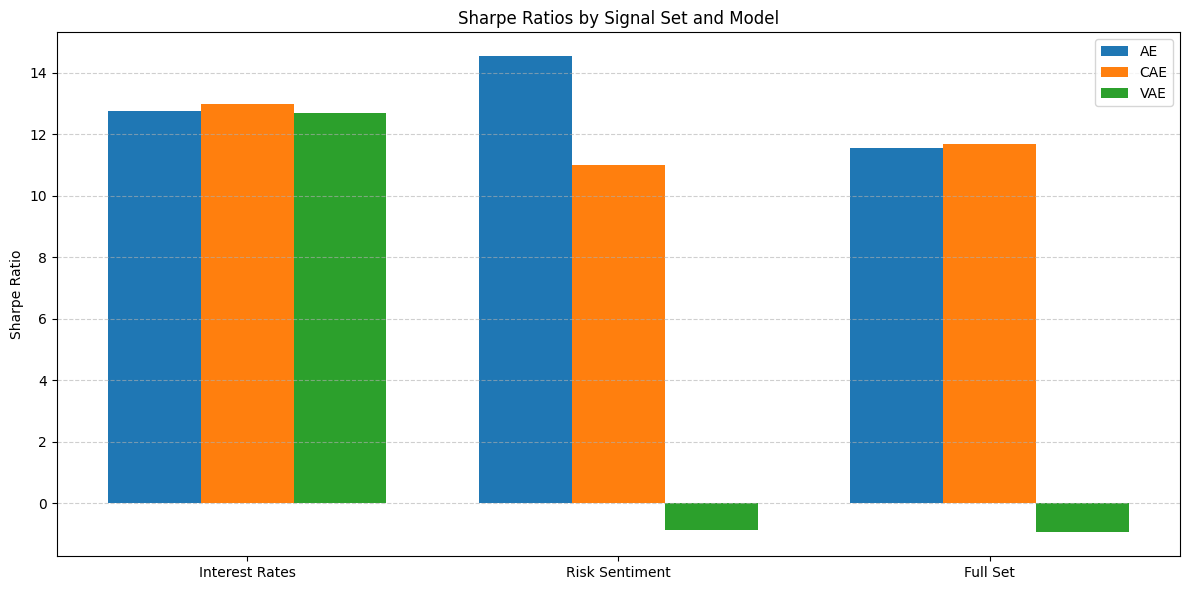

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Signal Set": [
        "Interest Rates", "Risk Sentiment", "Full Set"
    ],
    "AE Sharpe": [12.7565, 14.5394, 11.5637],
    "CAE Sharpe": [12.9955, 10.9919, 11.6900],
    "VAE Sharpe": [12.6920, -0.8766, -0.9414]
}

df = pd.DataFrame(data)

# Plot: grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(df))
bar_width = 0.25

ax.bar([p - bar_width for p in x], df["AE Sharpe"], width=bar_width, label="AE")
ax.bar(x, df["CAE Sharpe"], width=bar_width, label="CAE")
ax.bar([p + bar_width for p in x], df["VAE Sharpe"], width=bar_width, label="VAE")

ax.set_xticks(x)
ax.set_xticklabels(df["Signal Set"], rotation=0, ha='center')
ax.set_ylabel("Sharpe Ratio")
ax.set_title("Sharpe Ratios by Signal Set and Model")
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
